# 2 Kernelized SVM vs Neural Networks: Theory and Empirics

Comparing Empirical Performance of KSVMs and NNs: If both KSVMs and NNs have universal approximation (as seen in previous parts), then why are NNs more used in practice?

While both KSVMs and NNs are powerful models that can work well on arbitrarily complex datasets, on simpler datasets, we want models that require fewer training samples to yield good prediction. Here we will compare the relative performance of KSVMs and NNs on increasingly complex datasets and study which model class adapts better.

Download the dataset provided. It contains train and test samples of various sizes of (x, y) pairs of functions with increasing complexity. For this question, you may use any library you want.


### (i) To get a feel for the data, create scatter plots (x vs. y) using 50 training samples and 1000 training samples for each function complexity. (There are a total of 10 plots.)

In [316]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
import numpy as np
from sklearn.metrics import mean_squared_error
import torch
import tqdm
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import copy


In [251]:
root = '/Users/charlottewang/Documents/GitHub/Machine-Learning/hw/hw4/ksvm_nn_data'
folder = os.listdir(root)
file_paths=[]
train=[[]]*5
test=[[]]*5
for f in folder:
    if f.startswith('complexity'):
        file_paths.append(root+'/'+f)
for p in file_paths:
    files = os.listdir(p)
    for f in files:
        if f.endswith('train.csv'):
            #globals()['train_%s' % p[-1]] = pd.read_csv(p+'/'+f)
            train[int(p[-1])] = pd.read_csv(p+'/'+f)
        elif f.endswith('test.csv'):
            #globals()['test_%s' % p[-1]] = pd.read_csv(p+'/'+f)
            test[int(p[-1])] = pd.read_csv(p+'/'+f)


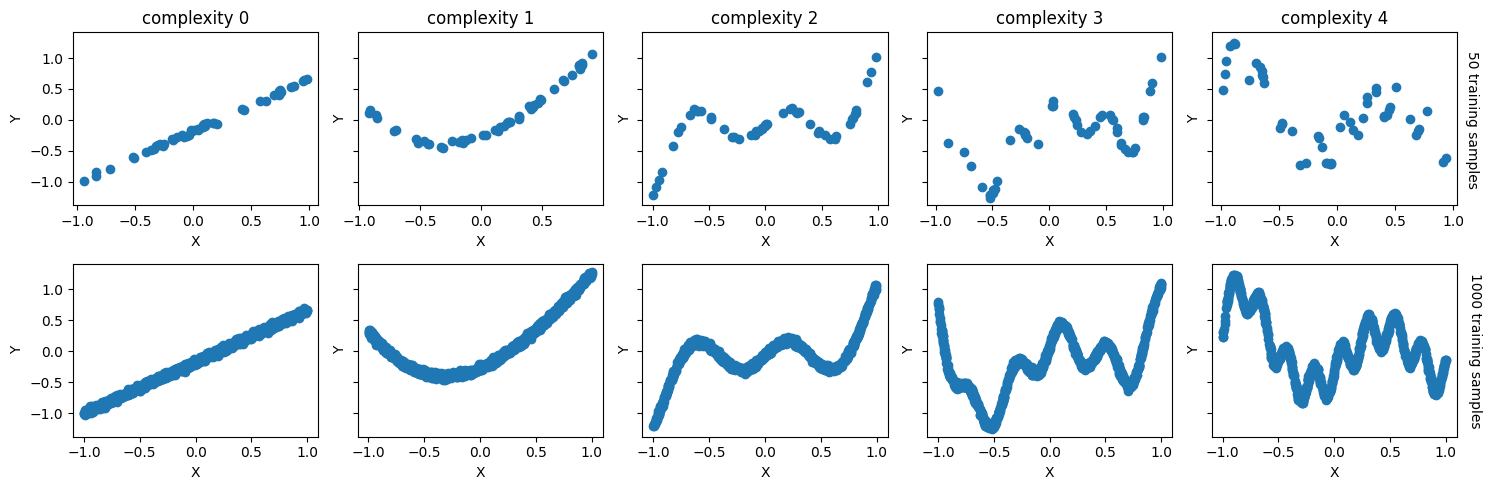

In [232]:
collections = ['Complexity 0', 'Complexity 1', 'Complexity 2', 'Complexity 3','Complexity 4']
fig, axes = plt.subplots(2, 5, figsize=(15, 5), sharey=True)

for i in range(5):
    axes[0,i].scatter(train[i]['x'][:50], train[i]['y'][:50])
    axes[0,i].set_xlabel('X')
    axes[0,i].set_ylabel('Y')
    axes[0,i].set_title(f'complexity {i}')
    if i == 4:
        axes[0,i].text(1.1,0,'50 training samples',verticalalignment='center',rotation=270) 
for i in range(5):
    axes[1,i].scatter(train[i]['x'][:1000], train[i]['y'][:1000])
    axes[1,i].set_xlabel('X')
    axes[1,i].set_ylabel('Y')
    if i == 4:
        axes[1,i].text(1.2,0,'1000 training samples',verticalalignment='center',rotation=270) 
plt.tight_layout()
plt.show()

(j) Train an RBF KSVM regressor and a NN for each function complexity with varying number of training samples.
Suggestions: 

For the SVM, it is advised you use SciKitLearn’s the built in Support Vector Regression function. The default settings should work fine, just ensure that you specify the right kernel. 

For the NN, it is advised you use PyTorch. Using a small neural network with 2 or 3 hidden layers and a dozen or a few dozen neurons per layer with the Adam optimizer and ReLU activation function should work well. To squeeze out good performance, try changing the number of epochs and the batch size first. Additionally, see this reference for more training tips: http://karpathy.github.io/2019/04/25/recipe/. You must use the MSE loss. 

For training sample sizes, consider sizes 50, 100, 300, 500, 750, and 1000.

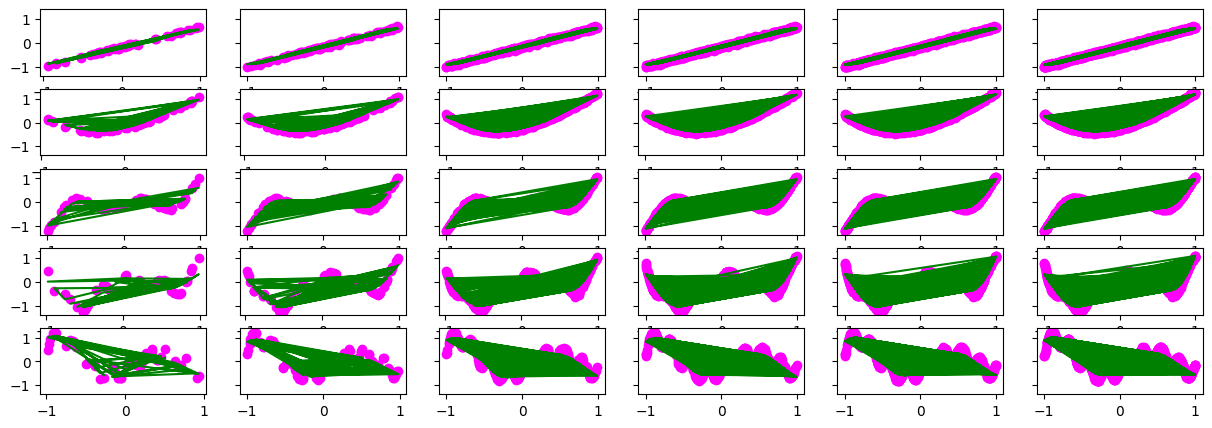

In [312]:
#RBF KSVM
svr = svm.SVR(kernel='rbf')
batch = [50, 100, 300, 500, 750, 1000]
mse_svm = np.zeros(shape=(5, len(batch)))
fig, axes = plt.subplots(5, 6, figsize=(15, 5), sharey=True)
for i in range(5):
    for b in range(len(batch)):
        train_x = np.array(train[i]['x']).reshape(-1,1)[:batch[b]]
        train_y = np.array(train[i]['y'])[:batch[b]]
        test_x = np.array(test[i]['x']).reshape(-1,1)
        test_y = np.array(test[i]['y'])
        svr.fit(train_x, train_y)
        pred_y = svr.predict(test_x)
        mse_svm[i][b]= mean_squared_error(test_y,pred_y)
        axes[i,b].scatter(train_x, train_y, color = 'magenta')
        axes[i,b].plot(train_x, svr.predict(train_x), color = 'green')
plt.show()

In [ ]:
# Neural Network
x_train_scaled=[[]]*5
x_test_scaled=[[]]*5
y_train_scaled=[[]]*5
y_test_scaled=[[]]*5
for i in range(5):
    x_train_scaled[i]=StandardScaler().fit_transform(np.array(train[i]['x']).reshape(-1,1))
    x_test_scaled[i]=StandardScaler().fit_transform(np.array(test[i]['x']).reshape(-1,1))
    y_train_scaled[i]=StandardScaler().fit_transform(np.array(train[i]['y']).reshape(-1,1))
    y_test_scaled[i]=StandardScaler().fit_transform(np.array(test[i]['y']).reshape(-1,1))
x_train_scaled=np.squeeze(x_train_scaled)
x_test_scaled=np.squeeze(x_test_scaled)
y_train_scaled=np.squeeze(y_train_scaled)
y_test_scaled=np.squeeze(y_test_scaled)
np.shape(x_train_scaled)

In [ ]:
model = nn.Sequential(
    nn.Linear(1000,1000),
    nn.ReLU(),
    nn.Linear(1000,1000),
    nn.ReLU(),
    nn.Linear(1000,1000),
)

loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [336]:
train_x0 = torch.tensor(train[0]['x'],dtype=torch.float32)
train_y0 = torch.tensor(train[0]['y'],dtype=torch.float32)
test_x0 = torch.tensor(test[0]['x'],dtype=torch.float32)
test_y0 = torch.tensor(test[0]['y'],dtype=torch.float32)

In [343]:
#complexity 0 
n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(train_x0), batch_size)

best_mse = np.inf   # init to infinity
best_weights = None
history = []

# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = train_x0[start:start+batch_size]
            y_batch = train_y0[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(test_x0)
    mse = loss_fn(y_pred, test_y0)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
print(best_mse)
# restore model and return best accuracy
model.load_state_dict(best_weights)

/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (1000) must match the size of tensor b (10) at non-singleton dimension 0

: 

### (k) For both KSVM and NN predictors, and each function complexity, plot the test MSE error for varying training sizes.

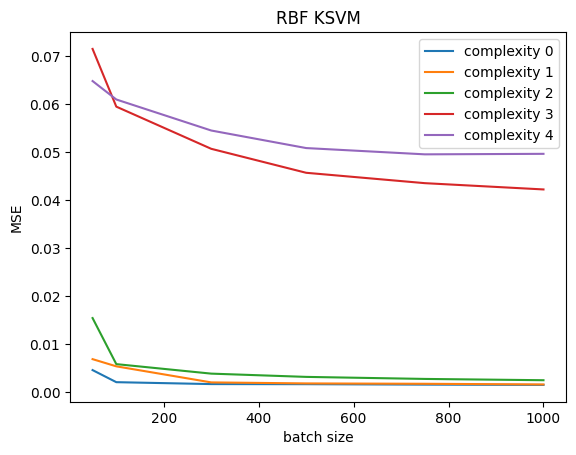

In [311]:
for i in range(5):
    plt.plot(batch, mse_svm[i],label=f'complexity {i}')
plt.xlabel('batch size')
plt.ylabel('MSE')
plt.title('RBF KSVM')
plt.legend()
plt.show()
    

In [321]:
from sklearn.datasets import fetch_california_housing
 
data = fetch_california_housing()
print(data.feature_names)
 
X, y = data.data, data.target
type(X)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


numpy.ndarray